In [40]:
# Import torch
import torch

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [41]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [42]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
# 2. Define transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# 3. Load dataset
data_dir = "../data/animals10" 
full_data = datasets.ImageFolder(root=data_dir, transform=transform)

# 4. Split dataset into train and test
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
val_data = torch.utils.data.random_split(full_data, [train_size, val_size])

# 5. Create DataLoader for test set
test_loader = DataLoader(val_data[1], batch_size=32, shuffle=False)




In [45]:
# 6 Define the model architecture (as trained)
import torch.nn.functional as F  # Import torch.nn.functional as F

class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):  # Fix indentation for the forward method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

In [46]:

# 6. Load the trained model
model = AnimalCNN().to(device)
model.load_state_dict(torch.load('../models/best_model.pth', map_location=device))
model.eval()

AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62352943..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].


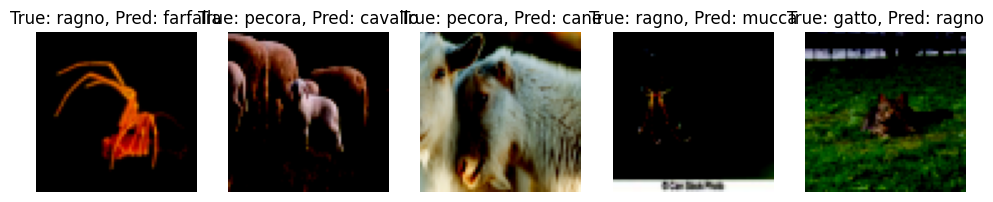

In [47]:

# Show misclassified images
misclassified_images = []
misclassified_labels = []
true_labels = []        


#7. Run predictions on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Show misclassified images
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(preds[i].cpu())
                true_labels.append(labels[i].cpu())

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Show first 5 misclassified images
def show_misclassified_images(images, true_labels, pred_labels):
    plt.figure(figsize=(12, 6))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(f"True: {full_data.classes[true_labels[i]]}, Pred: {full_data.classes[pred_labels[i]]}")
        plt.axis('off')
 

show_misclassified_images(misclassified_images, true_labels, misclassified_labels)


In [48]:

#8. classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_data.classes))

Classification Report:
              precision    recall  f1-score   support

        cane       0.78      0.78      0.78      1007
     cavallo       0.77      0.84      0.80       535
    elefante       0.86      0.67      0.75       276
    farfalla       0.76      0.90      0.82       425
     gallina       0.88      0.85      0.87       632
       gatto       0.64      0.63      0.64       317
       mucca       0.76      0.72      0.74       401
      pecora       0.81      0.64      0.71       364
       ragno       0.87      0.83      0.85       931
  scoiattolo       0.61      0.80      0.69       348

    accuracy                           0.78      5236
   macro avg       0.77      0.77      0.77      5236
weighted avg       0.79      0.78      0.78      5236



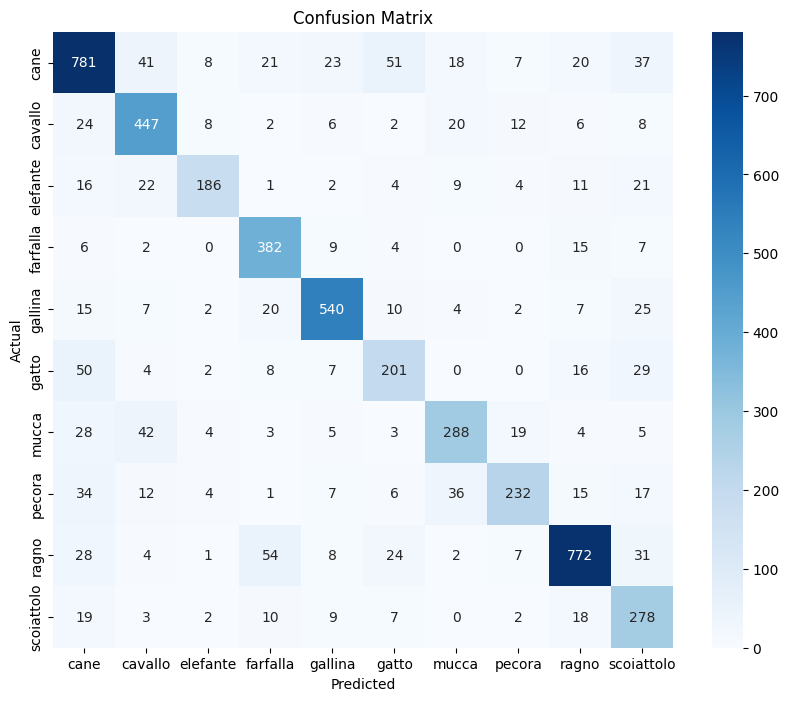

In [49]:
#9. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_data.classes, yticklabels=full_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()